# ADS-505 - Final Project - Team 5
## Modeling

In [ ]:
!pip install dmba

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly as ply

from sklearn.preprocessing import OneHotEncoder, Normalizer, StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, recall_score, accuracy_score, plot_confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB

from dmba import liftChart, gainsChart

import warnings
warnings.filterwarnings('ignore')

In [ ]:
cpa_df = pd.read_csv('https://usd-mads-projects.s3.us-west-1.amazonaws.com/ADS505/marketing_campaign.csv', sep='\t')
cpa_df.set_index(['ID'], inplace=True)
cpa_df.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


## Preprocessing


In [ ]:
# Mean Imputation
cpa_df['Income'] = cpa_df['Income'].fillna(cpa_df['Income'].mean())

# As of this project, the year is 2021
cpa_df['Age'] = 2021 - cpa_df['Year_Birth']

# Drop Year_Birth
cpa_df.drop(columns=['Year_Birth'], inplace=True)

cpa_df['Education'].replace({'2n Cycle': 'Master'}, inplace=True)
cpa_df['Marital_Status'].replace({'Alone': 'Single', 'Absurd': 'Single', 'YOLO': 'Single'}, inplace=True)

cpa_df['Children'] = cpa_df['Kidhome'] + cpa_df['Teenhome']
# Drop kidhome, teenhome
cpa_df.drop(columns=['Kidhome', 'Teenhome'], inplace=True)

# convert to datetime
cpa_df['Dt_Customer'] = pd.to_datetime(cpa_df['Dt_Customer'])
cpa_df['Customer_Years'] = (pd.to_datetime('today') - cpa_df['Dt_Customer']).dt.days / 365
# Drop Dt_Customer
cpa_df.drop(columns=['Dt_Customer'], inplace=True)

cpa_df['2year_Spend'] = cpa_df['MntWines'] + cpa_df['MntFruits'] + \
                        cpa_df['MntMeatProducts'] + cpa_df['MntFishProducts'] + \
                        cpa_df['MntSweetProducts'] + cpa_df['MntGoldProds']

cpa_df.drop(columns=['Z_CostContact', 'Z_Revenue'], inplace=True)


cpa_df['Respond_Any'] = cpa_df[['AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','AcceptedCmp1','AcceptedCmp2', 'Response']].any(axis=1)
cpa_df['Response_Count'] = cpa_df[['AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','AcceptedCmp1','AcceptedCmp2', 'Response']].sum(axis=1)

cpa_df = cpa_df[cpa_df['Age'] < 100]

# Convert Education to ordinal
cpa_df['Education'].replace({'Basic': 1, 'Graduation': 2, 'Master': 3, 'PhD': 4}, inplace=True)

# One Hot Encode Marital Status
cpa_df = pd.concat([cpa_df, pd.get_dummies(cpa_df['Marital_Status'], 'Marital', '_')], axis=1)
cpa_df.drop(columns='Marital_Status', inplace=True)

# Log Scale Income
cpa_df['Income'] = np.log(cpa_df['Income'])

# Cluster Labels
km_model = KMeans(n_clusters=3, random_state=42).fit(cpa_df)

# Append cluster assignments to dataframe
cpa_df['Cluster'] = km_model.labels_


## Training / Test Sets

In [ ]:
X = cpa_df.copy().drop(columns=['Cluster'])
y = cpa_df['Cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, random_state=42)

**Here we have multi-class target variable.It is common to model multi-class classification task with a model that predicts a Multinoulli probability distribution.**

Popular algorithms that can be used for multi-class classification include:   

*   Decision Trees.
*   Naive Bayes.
*   Random Forest.
*   Gradient Boosting.








# Models

In [ ]:
# Scaling
scale_vars = ['Income', 'Recency', 'MntWines',	'MntFruits',	
              'MntMeatProducts', 'MntFishProducts',	'MntSweetProducts',	
              'MntGoldProds', 'Age', 'Children', 'Customer_Years', '2year_Spend', 
              'Response_Count', 'NumDealsPurchases',	'NumWebPurchases',	
              'NumCatalogPurchases',	'NumStorePurchases',	'NumWebVisitsMonth']

X_train[scale_vars] = StandardScaler().fit_transform(X_train[scale_vars])
X_test[scale_vars] = StandardScaler().fit_transform(X_test[scale_vars])

## Decision Trees

In [ ]:
dt_scores = []

for i in range(2, 10, 2):
  dt_model = DecisionTreeClassifier(max_depth=i).fit(X_train, y_train)
  dt_pred = dt_model.predict(X_test)
  dt_scores.append({'Max Depth': i, 'Accuracy': accuracy_score(y_test, dt_pred), 
                    'Recall': recall_score(y_test, dt_pred, average='micro', pos_label=2)}) 

pd.DataFrame(dt_scores).set_index(['Max Depth'])

,Accuracy,Recall
Max Depth,,
2,0.955357,0.955357
4,0.961310,0.961310
6,0.967262,0.967262
8,0.974702,0.974702


In [ ]:
dt_model = RandomForestClassifier(max_depth=8).fit(X_train, y_train)

print(classification_report(y_test, dt_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       362
           1       0.94      0.95      0.95       189
           2       1.00      0.93      0.96       121

    accuracy                           0.97       672
   macro avg       0.97      0.96      0.96       672
weighted avg       0.97      0.97      0.97       672



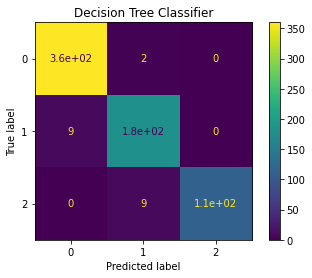

In [ ]:
plot_confusion_matrix(dt_model, X_test, y_test)
plt.title('Decision Tree Classifier')
plt.show()

## Random Forest

In [ ]:
rf_scores = []

for i in range(100, 1000, 100):
  for j in range(2, 10, 2):
    rf_model = RandomForestClassifier(n_estimators=i, max_depth=j, random_state=42).fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    rf_scores.append({'Num Trees': i, 'Max Depth': j, 'Accuracy': accuracy_score(y_test, rf_pred), 
                      'Recall': recall_score(y_test, rf_pred, average='micro', pos_label=2)}) 

pd.DataFrame(rf_scores).set_index(['Num Trees', 'Max Depth'])

Accuracy    Recall
Num Trees Max Depth                    
100       2          0.937500  0.937500
          4          0.964286  0.964286
          6          0.971726  0.971726
          8          0.974702  0.974702
200       2          0.922619  0.922619
          4          0.958333  0.958333
          6          0.968750  0.968750
          8          0.970238  0.970238
300       2          0.922619  0.922619
          4          0.959821  0.959821
          6          0.967262  0.967262
          8          0.970238  0.970238
400       2          0.919643  0.919643
          4          0.958333  0.958333
          6          0.965774  0.965774
          8          0.970238  0.970238
500       2          0.921131  0.921131
          4          0.959821  0.959821
          6          0.965774  0.965774
          8          0.970238  0.970238
600       2          0.922619  0.922619
          4          0.958333  0.958333
          6          0.965774  0.965774
          8          0.970238  0.970238
700       2          0.922619  0.922619
          4          0.958333  0.958333
          6          0.965774  0.965774
          8          0.970238  0.970238
800       2          0.924107  0.924107
          4          0.958333  0.958333
          6          0.965774  0.965774
          8          0.970238  0.970238
900       2          0.922619  0.922619
          4          0.958333  0.958333
          6          0.964286  0.964286
          8          0.968750  0.968750

Best parameters for Random Forest are 100 estimators with max depth of 8

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42).fit(X_train, y_train)

print(classification_report(y_test, rf_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       362
           1       0.95      0.96      0.96       189
           2       1.00      0.93      0.96       121

    accuracy                           0.97       672
   macro avg       0.98      0.96      0.97       672
weighted avg       0.98      0.97      0.97       672



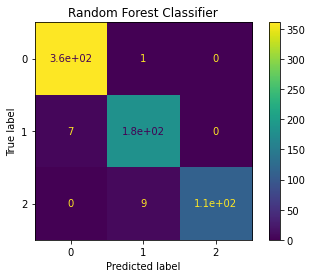

In [ ]:
plot_confusion_matrix(rf_model, X_test, y_test)
plt.title('Random Forest Classifier')
plt.show()

## Gradient Boosting

In [ ]:
gb_scores = []

for i in range(100, 1000, 100):
  for j in range(2, 10, 2):
    gb_model = GradientBoostingClassifier(n_estimators=i, max_depth=j, random_state=42).fit(X_train, y_train)
    gb_pred = gb_model.predict(X_test)
    gb_scores.append({'Num Trees': i, 'Max Depth': j, 'Accuracy': accuracy_score(y_test, gb_pred), 
                      'Recall': recall_score(y_test, gb_pred, average='micro', pos_label=2)}) 

pd.DataFrame(gb_scores).set_index(['Num Trees', 'Max Depth'])

Accuracy    Recall
Num Trees Max Depth                    
100       2          0.980655  0.980655
          4          0.979167  0.979167
          6          0.980655  0.980655
          8          0.971726  0.971726
200       2          0.980655  0.980655
          4          0.979167  0.979167
          6          0.980655  0.980655
          8          0.971726  0.971726
300       2          0.979167  0.979167
          4          0.979167  0.979167
          6          0.980655  0.980655
          8          0.971726  0.971726
400       2          0.979167  0.979167
          4          0.979167  0.979167
          6          0.980655  0.980655
          8          0.971726  0.971726
500       2          0.979167  0.979167
          4          0.979167  0.979167
          6          0.980655  0.980655
          8          0.971726  0.971726
600       2          0.979167  0.979167
          4          0.979167  0.979167
          6          0.980655  0.980655
          8          0.971726  0.971726
700       2          0.979167  0.979167
          4          0.979167  0.979167
          6          0.980655  0.980655
          8          0.971726  0.971726
800       2          0.979167  0.979167
          4          0.979167  0.979167
          6          0.980655  0.980655
          8          0.971726  0.971726
900       2          0.979167  0.979167
          4          0.979167  0.979167
          6          0.980655  0.980655
          8          0.971726  0.971726

In [ ]:
gb_model = GradientBoostingClassifier(n_estimators=100, max_depth=4, random_state=42).fit(X_train, y_train)

print(classification_report(y_test, gb_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       362
           1       0.97      0.96      0.96       189
           2       1.00      0.95      0.97       121

    accuracy                           0.98       672
   macro avg       0.98      0.97      0.98       672
weighted avg       0.98      0.98      0.98       672



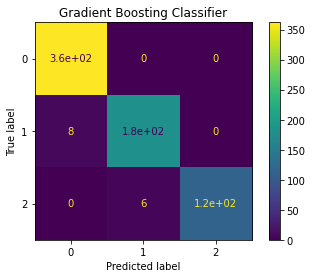

In [ ]:
plot_confusion_matrix(gb_model, X_test, y_test)
plt.title('Gradient Boosting Classifier')
plt.show()

## Naive Bayes

In [ ]:
# Can't have negative values in Naive Bayes, changing Standard scaling to Min/Max
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, random_state=42)

X_train[scale_vars] = Normalizer().fit_transform(X_train[scale_vars])
X_test[scale_vars] = Normalizer().fit_transform(X_test[scale_vars])

In [ ]:
nb_model = MultinomialNB().fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)

print(classification_report(y_test, nb_pred))

              precision    recall  f1-score   support

           0       0.69      0.94      0.79       362
           1       0.56      0.13      0.21       189
           2       0.59      0.64      0.61       121

    accuracy                           0.66       672
   macro avg       0.61      0.57      0.54       672
weighted avg       0.63      0.66      0.60       672



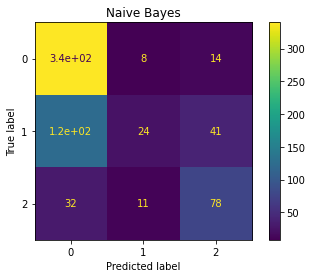

In [ ]:
plot_confusion_matrix(nb_model, X_test, y_test)
plt.title('Naive Bayes')
plt.show()

______


# Modeling Results

The primary metrics used for evaluation criteria are Recall (specifically for Class 2) and Overall Accuracy. Recall is an important metric since high true positive rates and low false negatives will result in lower missed opportunities for targeted marketing for Class 2 which has been identified as the most important target.  

**Decision Tree Summary**   

  * Performed well, overall accuracy of 97%
  * Recall on class 2 was 93%
  * Recall on class 1 was 95%
  * Recall on class 0 was 99%

**Random Forest Summary**   

  * Performed very well, overall accuracy of 97%
  * Recall on class 2 was 93%
  * Recall on class 1 was 96%
  * Recall on class 0 was 100%

**Gradient Boosting Summary**   

  * Best performing model
  * Overall accuracy of 98%
  * Recall on class 2 was 95%
  * Recall on class 1 was 96%
  * Recall on class 0 was 100%

**Multinomial Naive Bayes Summary**   

  * Worst performing model
  * Overall accuracy of 66%
  * Recall on class 2 was 64%
  * Recall on class 1 was 13%
  * Recall on class 0 was 94%


Based on the evaulation criteria, Gradient Boosting Model will be selected to classify customer data into one of the three key segments identified in K-Means clustering.  

